In [6]:
# Nếu bạn đã cài opencv-contrib-python và numpy bằng pip rồi thì có thể bỏ dòng !pip đi.
# Nếu dùng Jupyter trên máy local, bạn nên mở CMD/PowerShell cài trước:
# !pip install opencv-contrib-python numpy

import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# Để hiển thị ảnh ngay trong notebook
%matplotlib inline

print("OpenCV version:", cv2.__version__)


OpenCV version: 4.12.0


In [7]:
def stitch_two_images(img_left, img_right, ratio_thresh=0.75):
    """
    Ghép img_right vào bên phải img_left, trả về ảnh panorama.

    img_left: ảnh bên trái (BGR)
    img_right: ảnh bên phải (BGR)
    ratio_thresh: ngưỡng ratio-test cho SIFT matching
    """

    # 1. Chuyển sang xám
    gray1 = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    # 2. Tạo SIFT detector
    sift = cv2.SIFT_create()

    # 3. Tìm keypoint & descriptor
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    print("Số keypoints ảnh trái:", len(kp1))
    print("Số keypoints ảnh phải:", len(kp2))

    # 4. Matching bằng BFMatcher + KNN + ratio test
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    knn_matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in knn_matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    print("Số match tốt (good matches):", len(good_matches))

    if len(good_matches) < 10:
        raise ValueError("Quá ít match tốt, khó ghép panorama. Hãy chụp ảnh có vùng chồng lắp nhiều hơn.")

    # 5. Lấy toạ độ điểm tương ứng
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # 6. Tính homography dùng RANSAC
    # Ta muốn biến img_right về hệ toạ độ img_left: dst_pts -> src_pts
    H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    if H is None:
        raise ValueError("Không tìm được homography thích hợp!")

    # 7. Warp img_right sang hệ toạ độ img_left
    h1, w1 = img_left.shape[:2]
    h2, w2 = img_right.shape[:2]

    # Canvas: lấy rộng ~ w1 + w2, cao = max(h1, h2)
    pano_width = w1 + w2
    pano_height = max(h1, h2)

    warped_right = cv2.warpPerspective(img_right, H, (pano_width, pano_height))

    # 8. Dán img_left vào bên trái canvas
    panorama = warped_right.copy()
    panorama[0:h1, 0:w1] = img_left

    # 9. Cắt bớt vùng đen bên phải (nếu có)
    gray_pan = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_pan, 1, 255, cv2.THRESH_BINARY)

    # Tìm cột cuối cùng có pixel khác 0
    cols = np.where(np.max(thresh, axis=0) > 0)[0]
    if len(cols) > 0:
        max_col = cols[-1]
        panorama = panorama[:, :max_col + 1]

    return panorama, good_matches, kp1, kp2


Kích thước ảnh trái: (512, 384, 3)
Kích thước ảnh phải: (512, 384, 3)


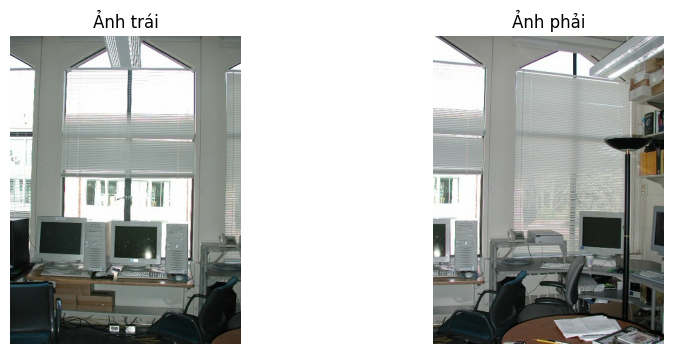

In [8]:
# Đường dẫn thư mục chứa notebook và ảnh
base_dir = r"C:\Users\Public\panorama_sift"

# Tên file ảnh (bạn chỉnh lại đuôi nếu khác .jpg)
left_name  = "src_left_2.jpg"
right_name = "src_right_2.jpg"

path_left  = os.path.join(base_dir, left_name)
path_right = os.path.join(base_dir, right_name)

img_left  = cv2.imread(path_left)
img_right = cv2.imread(path_right)

if img_left is None:
    raise FileNotFoundError(f"Không đọc được ảnh bên trái: {path_left}")
if img_right is None:
    raise FileNotFoundError(f"Không đọc được ảnh bên phải: {path_right}")

print("Kích thước ảnh trái:", img_left.shape)
print("Kích thước ảnh phải:", img_right.shape)

# Chuyển BGR -> RGB để hiển thị bằng matplotlib
img_left_rgb  = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
img_right_rgb = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img_left_rgb);  plt.title("Ảnh trái");  plt.axis("off")
plt.subplot(1,2,2); plt.imshow(img_right_rgb); plt.title("Ảnh phải"); plt.axis("off")
plt.show()


Số keypoints ảnh trái: 585
Số keypoints ảnh phải: 601
Số match tốt (good matches): 96


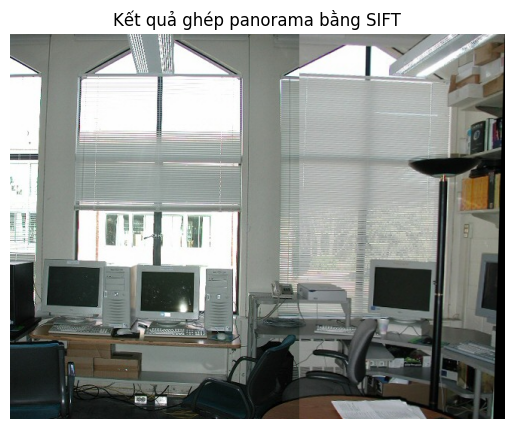

Đã lưu ảnh panorama tại: C:\Users\Public\panorama_sift\panorama_result_2.jpg


In [9]:
panorama_bgr, good_matches, kp1, kp2 = stitch_two_images(img_left, img_right)

# Đổi sang RGB để hiển thị
panorama_rgb = cv2.cvtColor(panorama_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,5))
plt.imshow(panorama_rgb)
plt.title("Kết quả ghép panorama bằng SIFT")
plt.axis("off")
plt.show()

# Lưu ảnh kết quả ra file
out_path = os.path.join(base_dir, "panorama_result_2.jpg")
cv2.imwrite(out_path, panorama_bgr)
print("Đã lưu ảnh panorama tại:", out_path)


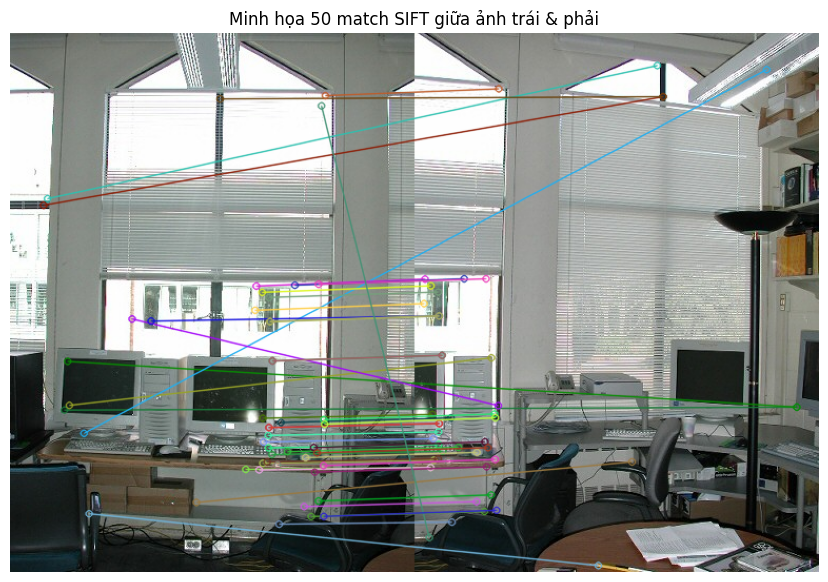

In [11]:
# Vẽ một số match tốt giữa hai ảnh để minh họa trong báo cáo
# Lấy tối đa 50 match để hình không quá rối
max_to_draw = min(50, len(good_matches))
matches_to_draw = good_matches[:max_to_draw]

match_img = cv2.drawMatches(
    img_left, kp1,
    img_right, kp2,
    matches_to_draw, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

match_img_rgb = cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,7))
plt.imshow(match_img_rgb)
plt.title(f"Minh họa {max_to_draw} match SIFT giữa ảnh trái & phải")
plt.axis("off")
plt.show()
